In [1]:
""" ---------------------------------------------------------------------------
                             Annual data analyses

- This code produce the figures and data for the annual analyses. 

"""
"""----------------------------------------------------------------------------
Importing libraries used in this script
----------------------------------------------------------------------------"""
from logging import PercentStyle
from matplotlib.pyplot import savefig
from numpy.random import sample
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from matplotlib.pylab import savefig as save
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn
import statsmodels.api as sm
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from statsmodels.stats.outliers_influence import summary_table
from xarray.core.duck_array_ops import count
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib as mpl
""" ---------------------------------------------------------------------------
defining functions used in this script
----------------------------------------------------------------------------"""


def outliers_index(data, m=3.5):
    """
    Returns true if a value is outlier
    
    :param int data: numpy array
    :param int m: # of std to include data 
    """
    import numpy as np
    d = np.abs(data - np.nanmedian(data))
    mdev = np.nanmedian(d)
    s = d / mdev if mdev else 0.
    return ~(s < m)


def bootstrap(x, y, sample_weights, n, seed):
    """Bootstraping the weighted linear regression
        """
    np.random.seed(seed)
    # add a column of ones
    X = np.vstack([x, np.ones(len(x))]).T
    predicts = []
    params = []
    for j in range(0, n):
        sample_index = np.random.choice(range(0, len(y)), len(y))
        X_samples = X[sample_index]
        y_samples = y[sample_index]
        w_samples = sample_weights[sample_index]
        mod_wls = sm.WLS(y_samples, X_samples, weights=w_samples)
        res_wls = mod_wls.fit()
        predict = res_wls.predict(X)
        par = np.round(res_wls.params, 3)
        predicts.append(predict)
        params.append(par)
    predicts = np.array(predicts).T
    params = np.array(params).T
    return params, predicts


def binning(df, bins, var):
    """
    Binning data
    """
    # Binning data based on bins intervals
    df["bins"] = pd.cut(df["dlcc"], bins=bins, include_lowest=True)
    # group data based on bins and get the weighted mean of each bin
    bins_mean = df.groupby('bins').mean()

    # uncomment following linesto set the threshold on minimum number
    # of data in each bin since our bins are very small (0.001) we did not set
    counts = df.groupby('bins').count()["dlcc"]
    # bins_mean = bins_mean.where(counts >= 5)

    # Get rid of bins when there is zero data
    x = bins[1:][bins_mean[var].notnull()]
    y = bins_mean[var][bins_mean[var].notnull()].values
    counts = counts[bins_mean[var].notnull()]
    out_list = [x, y, counts]
    return out_list


class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here


# The following class is to define my own cmap in matplotlib
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


yfmt = ScalarFormatterForceFormat()
yfmt.set_powerlimits((0, 0))
N_M = 10000  #Number of bootstrap
in_dir = ("/data/home/hamiddashti/nasa_above/outputs/")
out_dir = ("/data/home/hamiddashti/nasa_above/outputs/data_analyses/Annual/"
           "Albers/Figures_MS1/")

# out_dir = (
#     "/data/home/hamiddashti/mnt/nasa_above/working/modis_analyses/test/")

# The map of dLST due to LCC
# dlst_lcc = xr.open_dataarray(
#     in_dir + ("Natural_Variability/Natural_Variability_Annual_outputs/Albers/"
#               "dlst_lcc.nc"))
# dlst_total = xr.open_dataarray(
#     in_dir + ("Natural_Variability/Natural_Variability_Annual_outputs/Albers/"
#               "dlst_total.nc"))

# This is the results of confusion table script
ct = xr.open_dataset(
    in_dir + "Sensitivity/EndPoints/Annual/Albers/Confusion_Table_Albers.nc")

dlst = ct["DLST_MEAN_LCC"]  # Changed LST due to LCC
# weights = ct["WEIGHTS"]  # Weights based on area
# weights = xr.Variable("ID", np.ones(len(dlst)))  # All weights are one
det = ct["DET_LCC"]  # Changed ET due to LCC
dalbedo = ct["DALBEDO_LCC"]  # Changed albedo due to LCC
dlcc = ct["DLCC"]  # Fractional change in land cover
normalized_confusion = ct["NORMALIZED_CONFUSION"]  # Normalized confusion
I_dlst = outliers_index(dlst, 3.5)  # Outlier indices for dLST
I_dalbedo = outliers_index(dalbedo, 3.5)  # Outlier indices for dalbedo
I_det = outliers_index(det, 3.5)  # Outlier indices for det

# Remove outliers based on indices
dlst_clean = dlst.where((I_dlst == False) & (I_dalbedo == False)
                        & (I_det == False))
dalbedo_clean = dalbedo.where((I_dlst == False) & (I_dalbedo == False)
                              & (I_det == False))
det_clean = det.where((I_dlst == False) & (I_dalbedo == False)
                      & (I_det == False))

# weights_clean = weights.where(I_dlst == False)
# dlcc_clean = dlcc.where((I_dlst == False) & (I_dalbedo == False)
#                         & (I_det == False))
# normalized_confusion_clean = normalized_confusion.where((I_dlst == False)
#                                                         & (I_dalbedo == False)
#                                                         & (I_det == False))

dlcc_clean = dlcc
normalized_confusion_clean = normalized_confusion

palette = sns.color_palette("tab10")  # Color palette for plots
lc_names = [
    "EF", "DF", "Shrub", "Herbaceous", "Sparse", "Barren", "Fen", "Bog",
    "Shallow_Littoral", "Water"
]

t_list = []
lst_slopes = np.zeros((len(lc_names), len(lc_names)))
lst_slopes[:] = np.nan
lst_std = np.zeros((len(lc_names), len(lc_names)))
lst_std[:] = np.nan
for i in range(len(lc_names)):
    # Skip the bog and shallow and litteral classes due to very sparse
    # data points
    if (i == 7) | (i == 8) | (i == 9):
        continue
    print(f"Analyzing {lc_names[i]}")
    for k in range(len(lc_names)):
        if (k == 7) | (k == 8) | (k == 9) | (k == i):
            continue
        # If a transition plotted in the previous subplots skip it.
        t_list.append(str(i) + str(k))
        if (str(k) + str(i)) in t_list:
            continue
        print(f"{lc_names[i]} ----> {lc_names[k]}")
        # transintion_loss is transition of class i to class k
        transintion_loss = normalized_confusion_clean[:, i, k]
        df_loss = pd.DataFrame({
            "dlst": dlst_clean,
            # "w": weights_clean,
            "dlcc": -transintion_loss
        })
        df_loss = df_loss.dropna()
        bins_loss = np.linspace(-1, 0, 1001)
        df_loss["bins"] = pd.cut(df_loss["dlcc"],
                                 bins=bins_loss,
                                 include_lowest=True)
        out_loss = binning(df=df_loss, bins=bins_loss, var="dlst")
        # transintion_gain is transition of class k to class i
        transintion_gain = normalized_confusion_clean[:, k, i]
        df_gain = pd.DataFrame({
            "dlst": dlst_clean,
            # "w": weights_clean,
            "dlcc": transintion_gain,
        })
        df_gain = df_gain.dropna()
        bins_gain = np.linspace(0, 1, 1001)
        out_gain = binning(df=df_gain, bins=bins_gain, var="dlst")
        # Concatenate the loss and gain transitions and fit a linear model
        x = np.append(out_loss[0], out_gain[0])
        if ((np.min(x) > -0.5) | (np.max(x) < 0.5)):
            slope_mean = 0.0
            slope_std = 0.0
            intercept_mean = 0.0
            intercept_std = 0.0
            lst_slopes[i, k] = 0.0
            lst_std[i, k] = 0.0
            continue
        y = np.append(out_loss[1], out_gain[1])
        sample_weights = np.append(out_loss[2].values, out_gain[2].values)
        boot_reg = bootstrap(x=x,
                             y=y,
                             sample_weights=sample_weights,
                             n=N_M,
                             seed=1)
        # if ((np.min(x) > -0.5) | (np.max(x) < 0.5)):
        #     continue
        params = boot_reg[0]
        slope_mean = np.round(params[0, ].mean(), 3)
        slope_std = np.round(params[0, ].std(), 3)
        intercept_mean = np.round(params[1, ].mean(), 3)
        intercept_std = np.round(params[1, ].std(), 2)
        lst_slopes[i, k] = slope_mean
        lst_std[i, k] = slope_std

lst_slope_final = -lst_slopes[0:6, 1:7]
lst_std_final = lst_std[0:6, 1:7]

# ----------------------------------------------------------
t_list = []
et_slopes = np.zeros((len(lc_names), len(lc_names)))
et_slopes[:] = np.nan
et_std = np.zeros((len(lc_names), len(lc_names)))
et_std[:] = np.nan
for i in range(len(lc_names)):
    # Skip the bog and shallow and litteral classes due to very sparse
    # data points
    if (i == 7) | (i == 8) | (i == 9):
        continue
    print(f"Analyzing {lc_names[i]}")

    for k in range(len(lc_names)):
        if (k == 7) | (k == 8) | (k == 9) | (k == i):
            continue
        t_list.append(str(i) + str(k))
        if (str(k) + str(i)) in t_list:
            continue
        print(f"{lc_names[i]} transition to --> {lc_names[k]}")
        # transintion_loss is transition of class i to class k
        transintion_loss = normalized_confusion_clean[:, i, k]
        df_loss = pd.DataFrame({
            "dlst": dlst_clean,
            "dalbedo": dalbedo_clean,
            "det": det_clean,
            # "w": weights_clean,
            "dlcc": -transintion_loss
        })
        df_loss = df_loss.dropna()
        bins_loss = np.linspace(-1, 0, 1001)
        df_loss["bins"] = pd.cut(df_loss["dlcc"],
                                 bins=bins_loss,
                                 include_lowest=True)
        out_loss = binning(df=df_loss, bins=bins_loss, var="det")
        # transintion_gain is transition of class k to class i
        transintion_gain = normalized_confusion_clean[:, k, i]
        df_gain = pd.DataFrame({
            "dlst": dlst_clean,
            "dalbedo": dalbedo_clean,
            "det": det_clean,
            # "w": weights_clean,
            "dlcc": transintion_gain,
        })
        df_gain = df_gain.dropna()
        bins_gain = np.linspace(0, 1, 1001)
        out_gain = binning(df=df_gain, bins=bins_gain, var="det")
        x = np.append(out_loss[0], out_gain[0])
        if ((np.min(x) > -0.5) | (np.max(x) < 0.5)):
            slope_mean = 0.0
            slope_std = 0.0
            intercept_mean = 0.0
            intercept_std = 0.0
            et_slopes[i, k] = 0.0
            et_std[i, k] = 0.0
            continue
        y = np.append(out_loss[1], out_gain[1])
        sample_weights = np.append(out_loss[2].values, out_gain[2].values)
        boot_reg = bootstrap(x=x,
                             y=y,
                             sample_weights=sample_weights,
                             n=N_M,
                             seed=1)
        params = boot_reg[0]
        slope_mean = np.round(params[0, ].mean(), 3)
        slope_std = np.round(params[0, ].std(), 3)
        intercept_mean = np.round(params[1, ].mean(), 3)
        intercept_std = np.round(params[1, ].std(), 2)
        et_slopes[i, k] = slope_mean
        et_std[i, k] = slope_std

et_slope_final = -et_slopes[0:6, 1:7]
et_std_final = et_std[0:6, 1:7]

# --------------------------------------------------------------------------
t_list = []
albedo_slopes = np.zeros((len(lc_names), len(lc_names)))
albedo_slopes[:] = np.nan
albedo_std = np.zeros((len(lc_names), len(lc_names)))
albedo_std[:] = np.nan
for i in range(len(lc_names)):
    # Skip the bog and shallow and litteral classes due to very sparse
    # data points
    if (i == 7) | (i == 8) | ((i == 9)):
        continue
    print(f"Analyzing {lc_names[i]}")

    for k in range(len(lc_names)):
        if (k == 7) | (k == 8) | (k == 9) | (k == i):
            continue
        t_list.append(str(i) + str(k))
        if (str(k) + str(i)) in t_list:
            continue
        print(f"{lc_names[i]} transition to --> {lc_names[k]}")
        # transintion_loss is transition of class i to class k
        transintion_loss = normalized_confusion_clean[:, i, k]
        df_loss = pd.DataFrame({
            "dlst": dlst_clean,
            "dalbedo": dalbedo_clean,
            "det": det_clean,
            # "w": weights_clean,
            "dlcc": -transintion_loss
        })
        df_loss = df_loss.dropna()
        bins_loss = np.linspace(-1, 0, 101)
        df_loss["bins"] = pd.cut(df_loss["dlcc"],
                                 bins=bins_loss,
                                 include_lowest=True)
        out_loss = binning(df=df_loss, bins=bins_loss, var="dalbedo")
        # transintion_gain is transition of class k to class i
        transintion_gain = normalized_confusion_clean[:, k, i]
        df_gain = pd.DataFrame({
            "dlst": dlst_clean,
            "dalbedo": dalbedo_clean,
            "det": det_clean,
            # "w": weights_clean,
            "dlcc": transintion_gain,
        })
        df_gain = df_gain.dropna()
        bins_gain = np.linspace(0, 1, 101)
        out_gain = binning(df=df_gain, bins=bins_gain, var="dalbedo")
        x = np.append(out_loss[0], out_gain[0])
        if ((np.min(x) > -0.5) | (np.max(x) < 0.5)):
            slope_mean = 0.0
            slope_std = 0.0
            intercept_mean = 0.0
            intercept_std = 0.0
            albedo_slopes[i, k] = 0.0
            albedo_std[i, k] = 0.0
            continue
        y = np.append(out_loss[1], out_gain[1])
        sample_weights = np.append(out_loss[2].values, out_gain[2].values)
        boot_reg = bootstrap(x=x,
                             y=y,
                             sample_weights=sample_weights,
                             n=N_M,
                             seed=1)
        params = boot_reg[0]
        slope_mean = np.round(params[0, ].mean(), 3)
        slope_std = np.round(params[0, ].std(), 3)
        intercept_mean = np.round(params[1, ].mean(), 3)
        intercept_std = np.round(params[1, ].std(), 2)
        albedo_slopes[i, k] = slope_mean
        albedo_std[i, k] = slope_std

albedo_slope_final = -albedo_slopes[0:6, 1:7]
albedo_std_final = albedo_std[0:6, 1:7]

#######################




Analyzing EF
EF ----> DF
EF ----> Shrub
EF ----> Herbaceous
EF ----> Sparse
EF ----> Barren
EF ----> Fen
Analyzing DF
DF ----> Shrub
DF ----> Herbaceous
DF ----> Sparse
DF ----> Barren
DF ----> Fen
Analyzing Shrub
Shrub ----> Herbaceous
Shrub ----> Sparse
Shrub ----> Barren
Shrub ----> Fen
Analyzing Herbaceous
Herbaceous ----> Sparse
Herbaceous ----> Barren
Herbaceous ----> Fen
Analyzing Sparse
Sparse ----> Barren
Sparse ----> Fen
Analyzing Barren
Barren ----> Fen
Analyzing Fen
Analyzing EF
EF transition to --> DF
EF transition to --> Shrub
EF transition to --> Herbaceous
EF transition to --> Sparse
EF transition to --> Barren
EF transition to --> Fen
Analyzing DF
DF transition to --> Shrub
DF transition to --> Herbaceous
DF transition to --> Sparse
DF transition to --> Barren
DF transition to --> Fen
Analyzing Shrub
Shrub transition to --> Herbaceous
Shrub transition to --> Sparse
Shrub transition to --> Barren
Shrub transition to --> Fen
Analyzing Herbaceous
Herbaceous transition to 

all done!


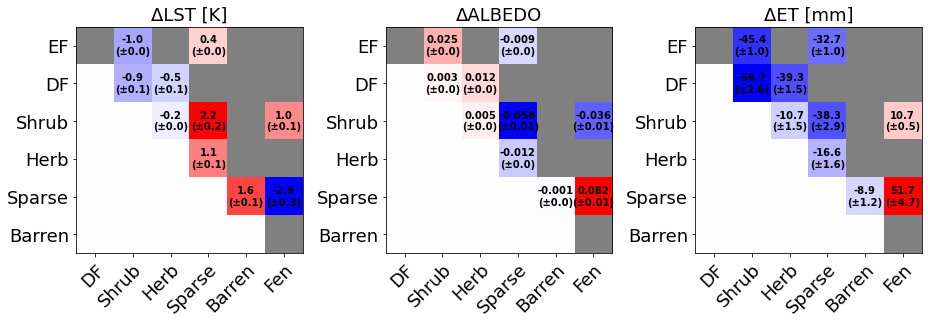

In [7]:
initial_state = ["EF", "DF", "Shrub", "Herb", "Sparse", "Barren"]
final_state = ["DF", "Shrub", "Herb", "Sparse", "Barren", "Fen"]
data_slope = [np.round(lst_slope_final,1), albedo_slope_final, np.round(et_slope_final,1)]
data_std = [np.round(lst_std_final,1), np.round(albedo_std_final,2), np.round(et_std_final,1)]
titles = ["\u0394LST [K]", "\u0394ALBEDO", "\u0394ET [mm]"]


plt.close()
ar = 1.0  # initial aspect ratio for first trial
wi = 13  # width of the whole figure in inches, ...
hi = wi * ar
rows, cols = 1, 3
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(wi, hi))

cmap = mpl.cm.get_cmap("bwr").copy()
cmap.set_bad(color='gray')
# cmap.set_under(color='gray')
for k in range(0, rows * cols):
    ax = plt.subplot(gs[k])
    a = np.nan_to_num(data_slope[k], nan=0.0)
    b = np.where(data_slope[k] == 0, np.nan, a)
    c = np.ma.masked_where(np.isnan(b), b)
    c.filled(np.nan)
    midnorm = MidpointNormalize(vmin=c.min(), vcenter=0, vmax=c.max())
    im = ax.imshow(c, cmap=cmap, norm=midnorm)
    ax.set_title(titles[k],fontsize=18)
    ax.set_xticks(np.arange(len(final_state)))
    ax.set_yticks(np.arange(len(initial_state)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(final_state,fontsize=18)
    ax.set_yticklabels(initial_state,fontsize=18)
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(initial_state)):
        for j in range(len(final_state)):
            if i > j:
                continue
            if data_slope[k][i, j] == 0:
                continue
            text = ax.text(j,
                           i,
                           str(data_slope[k][i, j]) + "\n(\u00B1" +
                           str(data_std[k][i, j]) + ")",
                           ha="center",
                           va="center",
                           color="black",
                           weight="heavy",
                           fontsize=10)

plt.draw()
xmin, xmax = ax.get_xbound()
ymin, ymax = ax.get_ybound()
y2x_ratio = (ymax - ymin) / (xmax - xmin) * rows / cols
fig.set_figheight(wi * y2x_ratio)
gs.tight_layout(fig)
plt.savefig(out_dir + "Figure2_heat_map_revised.png")
print("all done!")

